In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [3]:
print(sklearn.__version__)

0.24.1


In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [5]:
data = pd.read_csv('stoch_corr_atanh_rho_1000.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [166]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1000:1001]

In [159]:
d_observations = (observations)
d_observations.shape

# for i in tqdm(range(len(observations))):
#     for j in range(1, len(observations[i])):
#         print(d_observations[0])
#         # d_observations[i][j] = observations[i][j]-observations[i][j-1]

(100000, 999)

In [160]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(d_observations).reshape(100000,1,999)

In [60]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 998)


In [161]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.Dense(units=64, activation=tf.keras.activations.sigmoid, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.Dense(units=32, activation=tf.keras.activations.sigmoid))
model.add(layer=tf.keras.layers.Dense(units=32, activation=tf.keras.activations.sigmoid))
model.add(layer=tf.keras.layers.Dense(units=32, activation=tf.keras.activations.sigmoid))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 64)             64000     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)             2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              33        
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [162]:
model.compile(
    optimizer="adam",
    loss='mae',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.20, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/25
2500/2500 [==============================] - 11s 4ms/step - loss: 0.9991 - val_loss: 0.9998
Epoch 2/25
2500/2500 [==============================] - 11s 4ms/step - loss: 0.9987 - val_loss: 0.9998
Epoch 3/25
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9986 - val_loss: 0.9998


In [163]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 200, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 1.50:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    # print(test_output, params_reshape[i])

100%|██████████| 200/200 [00:10<00:00, 19.75it/s]


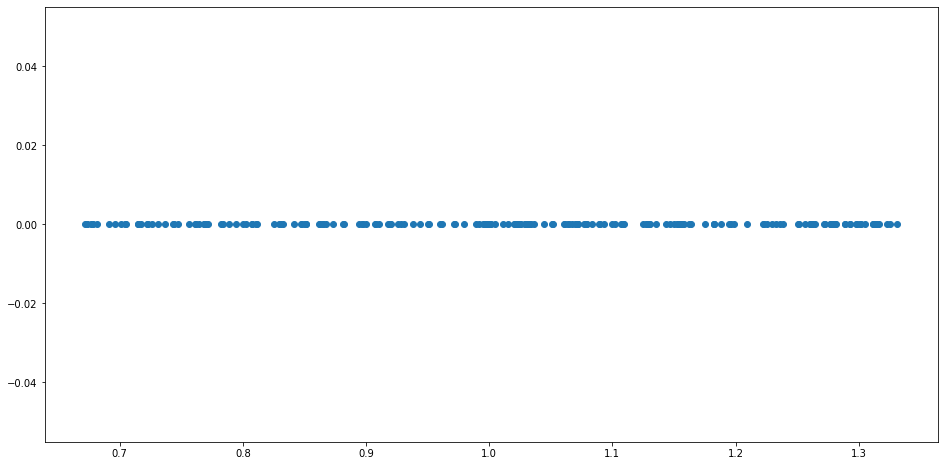

In [165]:
plt.figure(figsize=(16,8))
# plt.plot([6,12], [6,12], 'red')
plt.scatter(simulated, predicted)
plt.show()

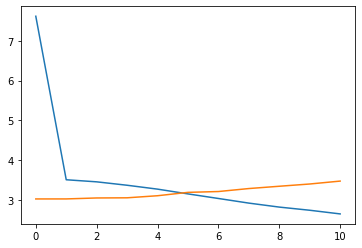

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()